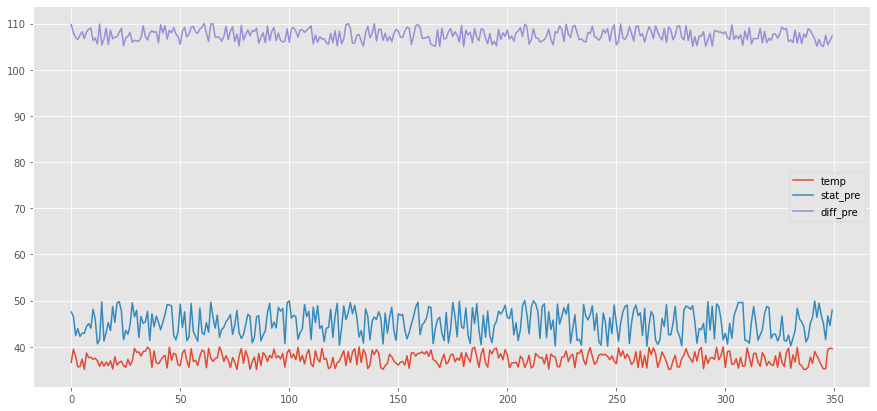

In [1]:
# import the necessary libraries
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use("ggplot")

SEED = 2023
np.random.seed(SEED)
random.seed(SEED)

# Load the digits dataset from scikit-learn
# digits = load_digits()
# X = digits.images
# y = digits.target

# Reshape the images to be in the form (number of samples, number of features)
# X = X.reshape((len(X), -1))

# Split the dataset into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def get_data(size=350):
    temp = np.round(np.random.uniform(low=35, high=40, size=size), 4)
    stp = np.round(np.random.uniform(low=40, high=50, size=size), 4)
    dfp = np.round(np.random.uniform(low=105, high=110, size=size), 4)
    df = pd.DataFrame({"temp": temp, "stat_pre": stp, "diff_pre": dfp})
    return df

data = get_data()
data.plot(figsize=(15, 7))
plt.show()
# Convert numpy arrays to torch tensors
X_train = data.sample(frac=250, replace=True)
X_test = data.sample(frac=50, replace=True)
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)

In [2]:
# Create custom activation functions
class Satlin(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # return torch.where(x > 0, x, x/(1 + torch.abs(x)))
        return torch.clamp(x, 0, 1)
    
class Purelin(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
# MAPE Metric for evaluation
class Mape(nn.Module):
    def forward(self, true, pred):
        num = torch.sum(torch.abs(true - pred))
        den = torch.sum(torch.abs(true)) * true.shape[0]
        mape = 100 * (num/den)
        return mape

In [3]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_param, beta):
        super(SparseAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity_param = sparsity_param
        self.beta = beta
        self.satlin = Satlin()
        self.purelin = Purelin()
        
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.satlin(x)
        x = self.decoder(x)
        x = self.purelin(x)
        
        avg_act = torch.mean(x, dim=0)
        
        # sparsity_loss = self.sparsity_param * torch.log(self.sparsity_param / avg_act) + \
        #     (1 - self.sparsity_param) * torch.log((1 - self.sparsity_param) / (1 - avg_act))
        sparsity_loss = self.sparsity_param * torch.log(self.sparsity_param / avg_act) + \
                        torch.log((1-self.sparsity_param)/(1-avg_act))
        
        sparsity_loss = self.beta * torch.sum(sparsity_loss)
        
        return x, sparsity_loss

In [4]:
def train(model, train_loader, criterion, optimizer, beta):
    model.train()
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        outputs, sparsity_loss = model(data)
        loss = criterion(outputs, data) + sparsity_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        m = mape(data, outputs)
    return train_loss / len(train_loader), m

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    for data in test_loader:
        with torch.no_grad():
            outputs, _ = model(data)
            loss = criterion(data, outputs)
            m = mape(data, outputs)
            test_loss += loss
    # print(f"Test loss: {test_loss/len(test_loader):.4f}, Test MAPE: {m:.4f}")
    return test_loss/len(test_loader), m

In [6]:
input_size = 3
hidden_size = 10
sparsity_param = 0.05
beta = 3

model = SparseAutoencoder(input_size, hidden_size, sparsity_param, beta)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
mape = Mape()

# Replace this with your own data loading code
train_loader = X_train
test_loader = X_test

n_epochs = 4
for epoch, _ in enumerate(tqdm(range(n_epochs), desc='Training model', total=n_epochs)):
    train_loss, m = train(model, train_loader, criterion, optimizer, beta)
    test_loss, test_m = test(model, test_loader, criterion)
    
    acc = 100 - m
    test_acc = 100 - test_m
    print(f"Epoch: [{epoch}/{n_epochs}] Train Loss: {train_loss:.4f}, Train MAPE: {m:.4f}, Train Acc: {acc:.4f}")
    print(f"Epoch: [{epoch}/{n_epochs}] Test Loss: {test_loss:.4f}, Test MAPE: {test_m:.4f}, Test Acc: {test_acc:.4f}\n")

Training model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: [0/4] Train Loss: nan, Train MAPE: 0.2298, Train Acc: 99.7702
Epoch: [0/4] Test Loss: 3.9486, Test MAPE: 0.7968, Test Acc: 99.2032

Epoch: [1/4] Train Loss: nan, Train MAPE: 0.2298, Train Acc: 99.7702
Epoch: [1/4] Test Loss: 3.9486, Test MAPE: 0.7968, Test Acc: 99.2032

Epoch: [2/4] Train Loss: nan, Train MAPE: 0.2298, Train Acc: 99.7702
Epoch: [2/4] Test Loss: 3.9486, Test MAPE: 0.7968, Test Acc: 99.2032

Epoch: [3/4] Train Loss: nan, Train MAPE: 0.2298, Train Acc: 99.7702
Epoch: [3/4] Test Loss: 3.9486, Test MAPE: 0.7968, Test Acc: 99.2032



In [9]:
model.sparsity_param

0.05